# Application of Machine Learning on Air Pollution Forecasting
## Problem Background

Air pollution is contamination of the indoor or outdoor environment by any chemical, physical or biological agent that modifies the natural characteristics of the atmosphere.
According to the World Health Organisation ,more than 7 millions of people dead from air pollution per year.

The specific disease outcomes most strongly linked with exposure to air pollution include stroke, ischaemic heart disease, chronic obstructive pulmonary disease, lung cancer, pneumonia, and cataract (household air pollution only).  

There is suggestive evidence also linking air pollution exposure with increased risk for adverse pregnancy outcomes (i.e. low-birth weight, small for gestational age), other cancers, diabetes, cognitive impairment and neurological diseases. 

Moreover, air pollution also caused a large impact to the environment.Air pollution can accelerate the presence of greenhouse effect leading to more extreme weather effect and climate.

However,reducing air pollution is a long term effort and requires the cooperations of many countries. In order to mitigrate the issue, countries need to set a target every few years to keep track whether they are on the right path. Therefore in this situation, forecasting could be use to predict the future trend. The obtained result can then be used to carried out some caclulation and be set ad the target for the country.

In this experiment,we will attempt to use machine learning and evaluate a forecasting model that has the highest performance in predicting the pollution gases over a interval.


## Problem Statement
How can we make use of machine learning to predict pollution gases over time?

## Install Dependencies

In [2]:
!pip install numpy matplotlib pandas seaborn scikit-learn==1.0.2 yellowbrick phik statsmodels pyampute xgboost imblearn missingno tqdm mlxtend category-encoders

     |████████████████████████████████| 78 kB 4.7 MB/s eta 0:00:011
     |████████████████████████████████| 69 kB 7.7 MB/s  eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


## Import Libraries

In [3]:
# Utility
from os import path
from os.path import exists # We use this to check if a file exists
from tqdm import tqdm # Use this to track how much time each iter of a for loop takes
import warnings # Statsmodels likes to throw out warnings. Some of them are important, some are not
from statsmodels.tools.sm_exceptions import *
from collections import defaultdict 
from statsmodels.api import load # load serialized models


# Statistical Analysis
## General
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm

## Time Series
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt

## Model Validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


# Graphical Plots
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set()
plt.rcParams['figure.figsize'] = (13, 8)

## Data Ingestion

In [19]:
df=pd.read_csv('train.csv',usecols=[0,1,2,3,4], na_values=[-200])
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df.set_index("Date", inplace=True)
df

,Date,T,RH,Gas,Value
0,15/3/2016,12.020833,54.883334,CO,1053.200000
1,16/3/2016,9.833333,64.069791,CO,995.250000
2,17/3/2016,11.292708,51.107292,CO,1025.250000
3,18/3/2016,12.866319,51.530903,CO,1064.444444
4,19/3/2016,16.016667,48.843750,CO,1088.741667
...,...,...,...,...,...
1307,1/2/2017,5.267708,39.614930,O3,553.180556
1308,2/2/2017,-55.515972,-24.010417,O3,343.500000
1309,3/2/2017,-14.272917,28.563542,O3,334.458333
1310,4/2/2017,4.848611,37.832986,O3,379.513889


In [21]:
data=pd.concat([pd.pivot(df, values="Value", columns="Gas"),df[["T", "RH"]].groupby(df.index).mean()],axis=1)
data

,CO,HC,NO2,O3,T,RH
Date,,,,,,
2016-03-15,1053.200000,729.800000,933.800000,876.833333,12.020833,54.883334
2016-03-16,995.250000,681.441667,1021.750000,708.025000,9.833333,64.069791
2016-03-17,1025.250000,806.583333,881.375000,867.375000,11.292708,51.107292
2016-03-18,1064.444444,794.258333,794.527778,996.625000,12.866319,51.530903
2016-03-19,1088.741667,755.083333,800.883333,987.341667,16.016667,48.843750
...,...,...,...,...,...,...
2017-02-01,729.422222,562.650000,797.647222,553.180556,5.267708,39.614930
2017-02-02,474.291667,347.480556,508.180556,343.500000,-55.515972,-24.010417
2017-02-03,615.700000,414.475000,819.733333,334.458333,-14.272917,28.563542


## Data Exploration

In [26]:
(data.index == data.asfreq("D").index).all()

True

### Data Structure

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 328 entries, 2016-03-15 to 2017-02-05
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO      328 non-null    float64
 1   HC      328 non-null    float64
 2   NO2     328 non-null    float64
 3   O3      328 non-null    float64
 4   T       322 non-null    float64
 5   RH      322 non-null    float64
dtypes: float64(6)
memory usage: 17.9 KB


### Descriptive Statistic

In [23]:
data.describe()

,CO,HC,NO2,O3,T,RH
count,328.000000,328.000000,328.000000,328.000000,322.000000,322.000000
mean,840.583477,729.588974,650.087974,780.614931,15.578425,44.343425
std,204.831525,190.472814,193.658229,261.846007,23.412864,28.487081
min,-160.000000,-160.000000,-160.000000,-160.000000,-191.164583,-188.839583
25%,779.191667,662.795833,566.095833,639.850000,12.627083,37.101042
50%,864.141667,753.681944,659.325000,794.893056,18.993750,46.452083
75%,946.431250,847.712500,754.351389,944.608333,25.714149,58.028386
max,1210.566667,1084.083333,1342.950000,1436.233333,32.997917,81.104167


### Invalid Data

In [68]:
print(str(len(data[(data < 0.00).any(axis=1)])) + " rows of invalid data found")
data[(data < 0.00).any(axis=1)]

8 rows of invalid data found


,CO,HC,NO2,O3,T,RH
Date,,,,,,
2016-04-06,850.991667,687.247222,596.386111,789.052778,-11.426042,19.742014
2016-05-30,598.225000,569.850000,623.550000,557.075000,-23.920833,NaN
2016-06-26,606.991667,630.991667,560.566667,519.941667,-12.148958,NaN
2016-08-14,652.894444,566.805556,486.658333,590.861111,-9.852431,9.186111
2016-09-02,642.800000,555.500000,566.891667,493.341667,-0.613542,9.307292
2016-12-29,844.372222,712.916667,317.875000,1205.241667,-36.022917,4.436111
2017-01-07,745.391667,542.716667,545.166667,828.241667,-19.247917,26.868750
2017-02-03,615.700000,414.475000,819.733333,334.458333,-14.272917,28.563542


In [67]:
temp=data.iloc[:, [0,1,2,3,5]].copy()
data.iloc[:, [0,1,2,3,5]][data.iloc[:, [0,1,2,3,5]] < 0] = np.nan
data.iloc[:, [0,1,2,3,5]]=temp
data['T'][data['T'] < -50] = np.nan
data

/tmp/ipykernel_2371208/343705172.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.iloc[:, [0,1,2,3,5]][data.iloc[:, [0,1,2,3,5]] < 0] = np.nan
/tmp/ipykernel_2371208/343705172.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.iloc[:, [0,1,2,3,5]][data.iloc[:, [0,1,2,3,5]] < 0] = np.nan


,CO,HC,NO2,O3,T,RH
Date,,,,,,
2016-03-15,1053.200000,729.800000,933.800000,876.833333,12.020833,54.883334
2016-03-16,995.250000,681.441667,1021.750000,708.025000,9.833333,64.069791
2016-03-17,1025.250000,806.583333,881.375000,867.375000,11.292708,51.107292
2016-03-18,1064.444444,794.258333,794.527778,996.625000,12.866319,51.530903
2016-03-19,1088.741667,755.083333,800.883333,987.341667,16.016667,48.843750
...,...,...,...,...,...,...
2017-02-01,729.422222,562.650000,797.647222,553.180556,5.267708,39.614930
2017-02-02,474.291667,347.480556,508.180556,343.500000,NaN,NaN
2017-02-03,615.700000,414.475000,819.733333,334.458333,-14.272917,28.563542


### Missing Data

In [71]:
pd.DataFrame(data.isna().sum().sort_values(ascending=False),columns=['Number of missing data'])

,Number of missing data
RH,16
T,14
HC,8
NO2,8
O3,8
CO,7


In [73]:
data[data.isnull().any(axis=1)]

,CO,HC,NO2,O3,T,RH
Date,,,,,,
2016-04-14,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-30,598.225000,569.850000,623.550000,557.075000,-23.920833,NaN
2016-05-31,489.027778,530.961111,480.750000,514.877778,NaN,NaN
2016-06-24,385.402778,326.963889,362.972222,305.705556,NaN,NaN
2016-06-25,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-26,606.991667,630.991667,560.566667,519.941667,-12.148958,NaN
2016-08-31,48.866667,14.841667,82.016667,NaN,NaN,NaN
2016-09-01,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-13,180.166667,182.550000,92.991667,228.008333,NaN,NaN


<AxesSubplot:title={'center':'Number of missing value in features'}>

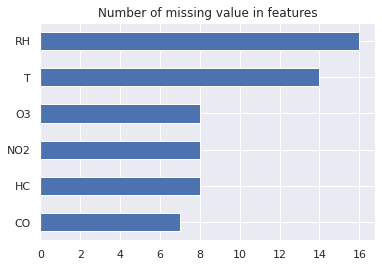

In [74]:
data.isna().sum().sort_values().plot.barh(title='Number of missing value in features')

<AxesSubplot:>

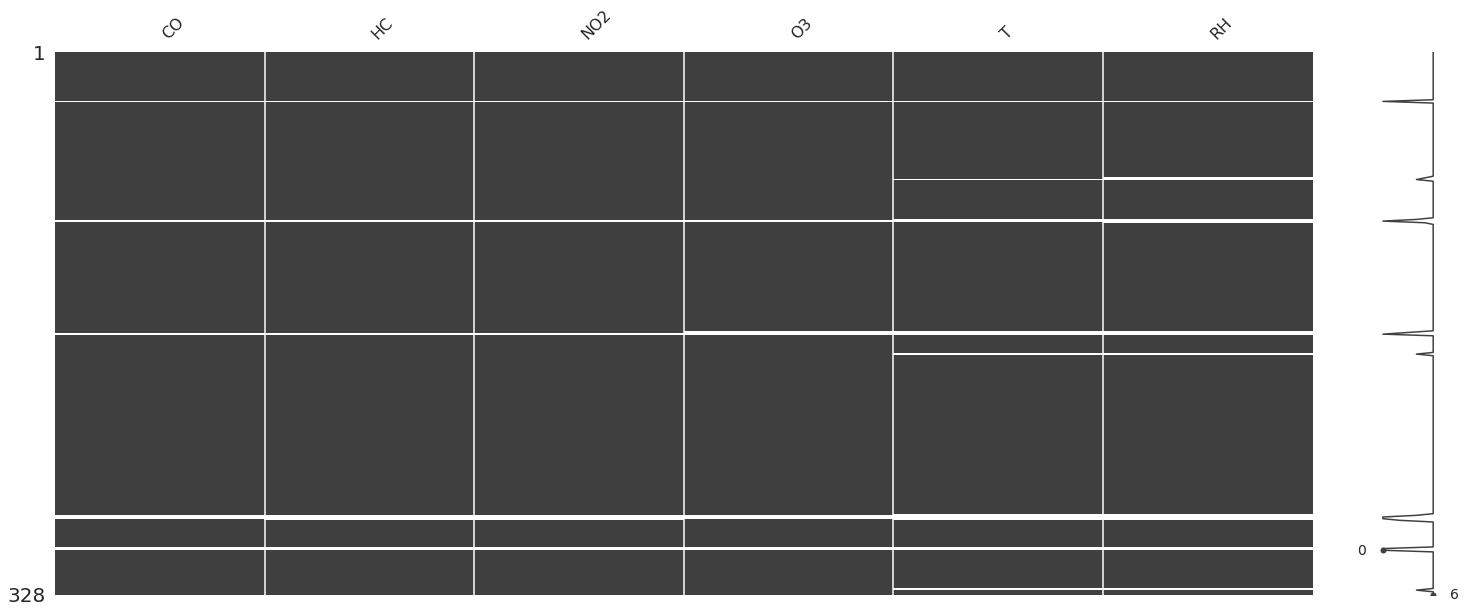

In [76]:
import missingno as msno
msno.matrix(data)

### Outliers

In [127]:

def outlier_detection(target=None,windows=7,name='My Plot',ax=plt):
    mean = target.ewm(windows).mean()
    std = target.ewm(windows).std()
    std[0] = 0 


    is_outlier = (target > (mean + 2*std)) | (target < (mean - 2*std))
    


    ax.plot(target, c = 'b', label = 'Actual Values')
    ax.plot(mean, c = 'r', label = 'Exponentially Weighted Moving Average')
    ax.plot((mean + 2*std), 'k--', label = 'Prediction Bounds')
    ax.plot((mean - 2*std), 'k--')
    ax.set_title(name)
    ax.scatter(target[is_outlier].index, target[is_outlier], c = 'r', marker = 'o', s = 120, label = 'Outliers')
    ax.legend()
    return is_outlier

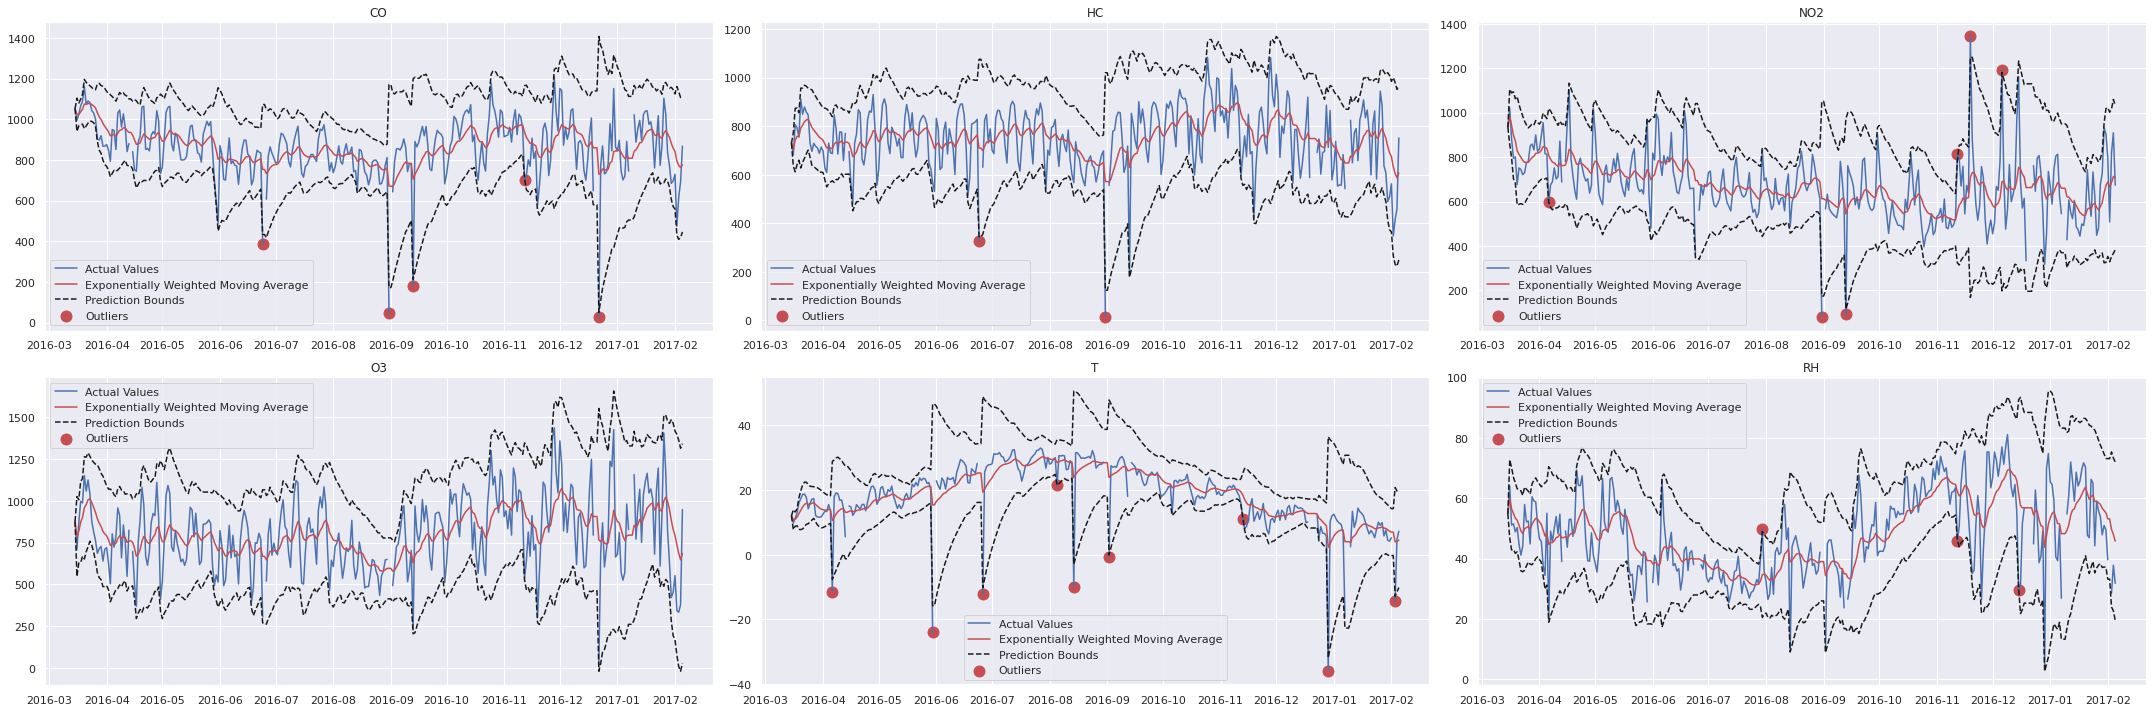

In [128]:
fig, ax = plt.subplots(2, 3, figsize=(30, 10), tight_layout=True)
ax = ax.flatten()
for col,name in enumerate(data.columns):
    outlier_detection(data[name],7,name,ax[col])

### Distribution

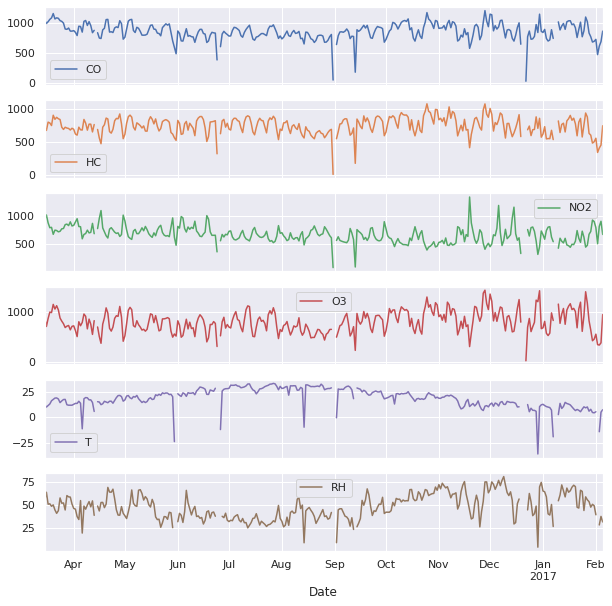

In [80]:
data.plot(subplots=True, figsize=(10, 10))
plt.show()

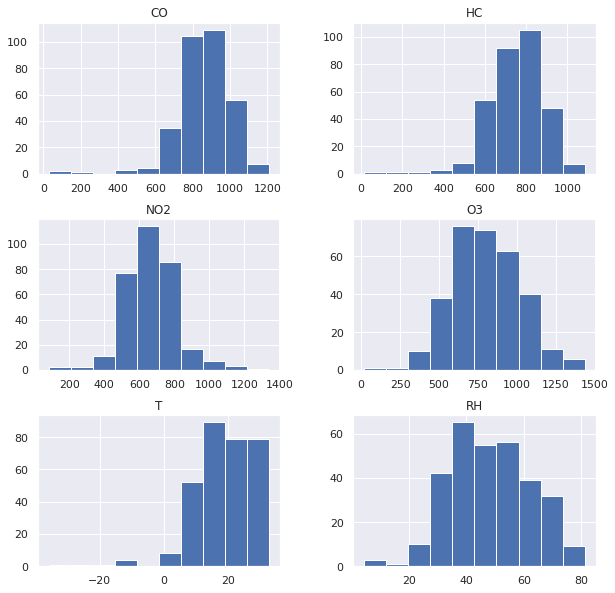

In [83]:
data.hist(figsize=((10,10)))
plt.show()

### Managing Missing Data

In [141]:
cdata=data.fillna(method= 'ffill')
cdata.isna().sum()

CO     0
HC     0
NO2    0
O3     0
T      0
RH     0
dtype: int64

### Seasonal and Trend decomposition using Loess

In [193]:
def strength(stl=None,element='Unknown element',record=pd.DataFrame({'Name':[],'Seasonality':[],'Trend':[]})):
    trend=max(0,1-(stl.resid.var())/(stl.trend+stl.resid).var())
    season=max(0,1-(stl.resid.var())/(stl.seasonal+stl.resid).var())
    print('The trend and seasonality have a strength of '+str(trend)+', '+str(season)+' respectively.')
    record=pd.concat([record,pd.DataFrame({'Name':[element],'Seasonality':[season],'Trend':[trend]})],ignore_index=True)
    return pd.DataFrame({'Name':[element],'Seasonality':[season],'Trend':[trend]}),record
    

In [194]:
from statsmodels.tsa.seasonal import STL
def STLDecomposition(target,):
    stl = STL(target,robust=True)
    res = stl.fit()
    fig = res.plot()
    return res

The trend and seasonality have a strength of 0.3760618021939587, 0.06989822173943094 respectively.


,Name,Seasonality,Trend
0,CO,0.069898,0.376062


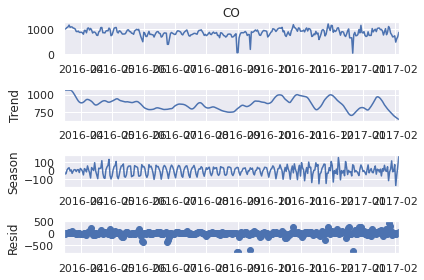

In [202]:
current,record=strength(STLDecomposition(cdata.CO),'CO')
current


The trend and seasonality have a strength of 0.5556699347661185, 0.010761880005307312 respectively.


,Name,Seasonality,Trend
0,Temperature,0.010762,0.55567


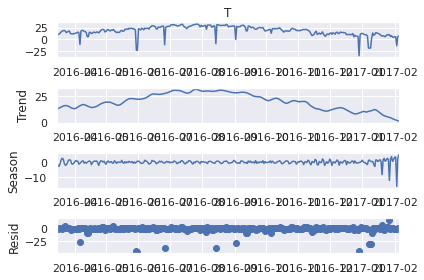

In [203]:
current,record=strength(STLDecomposition(cdata['T']),'Temperature',record)
current


The trend and seasonality have a strength of 0.3046283014760829, 0.10834906210028616 respectively.


,Name,Seasonality,Trend
0,NO2,0.108349,0.304628


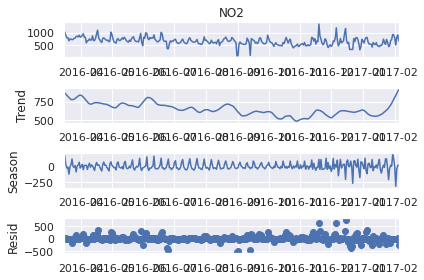

In [204]:
current,record=strength(STLDecomposition(cdata['NO2']),'NO2',record)
current



The trend and seasonality have a strength of 0.5976729280803192, 0.04314376542162868 respectively.


,Name,Seasonality,Trend
0,Relative Humidity,0.043144,0.597673


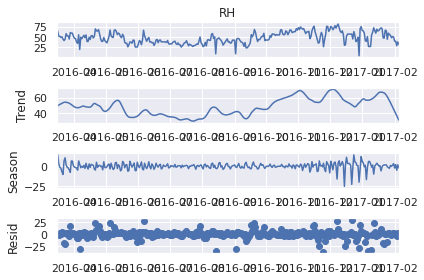

In [205]:
current,record=strength(STLDecomposition(cdata['RH']),'Relative Humidity',record)
current


The trend and seasonality have a strength of 0.3986361282869002, 0.24682814373900508 respectively.


,Name,Seasonality,Trend
0,O3,0.246828,0.398636


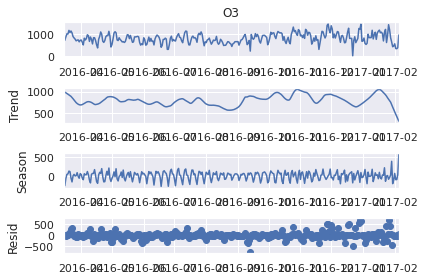

In [206]:

current,record=strength(STLDecomposition(cdata['O3']),'O3',record)
current



The trend and seasonality have a strength of 0.3144984358485019, 0.22785812424381635 respectively.


,Name,Seasonality,Trend
0,HC,0.227858,0.314498


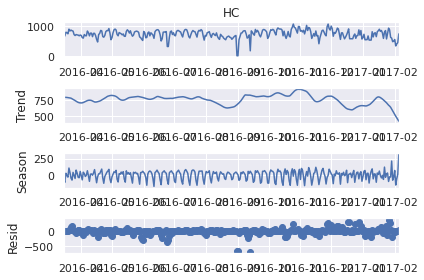

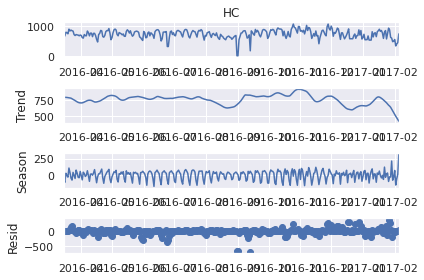

In [207]:
STLDecomposition(cdata['HC'])


current,record=strength(STLDecomposition(cdata['HC']),'HC',record)
current



### Measuring Trend and Seasonality

In [208]:
record

,Name,Seasonality,Trend
0,CO,0.069898,0.376062
1,Temperature,0.010762,0.555670
2,NO2,0.108349,0.304628
3,Relative Humidity,0.043144,0.597673
4,O3,0.246828,0.398636
5,HC,0.227858,0.314498


### Managing Outliers

## Training Data and Test Data

## Modelling and Evaluation